In [1]:
from edc import check_compatibility
check_compatibility("user-2022.07-00", dependencies=[])

# Australian Bushfires

## Geo-storytelling with EODASHBOARD and the Euro Data Cube - Notebook #2

In this notebook:

- [Australian Bushfires story on EODASHBOARD](#EODASHBOARD-Australian-Bushfires-Story)
- [Setting an Area of Interest from Open Street Map and Displaying it on a map](#New-South-Wales-AOI)
- [Visualising Sentinel-2 data during the bushfire season](#Visualising-Sentinel-2-data-during-the-bushfire-season)
- [Visualising Sentinel-2 indices - SWIR](#Request-all-bands-of-the-Sentinel-2-image)
- [Getting Carbon Monoxide Data from Sentinel-5p](#Getting-Carbon-Monoxide-Data-from-Sentinel-5p)

### EODASHBOARD Australian Bushfires Story


Australian bushfires in 2019-2020 emitted 700 million metric tons of CO2 into the atmosphere. 

To access the full story on the Australian Bushfires that took place in 2019-2020 season visit the [Atmosphere Section on EO Dashboard](https://www.eodashboard.org/story?id=australian-bushfires).

Atmosphere Datasets can be explored on EO Dashboard in the EXPLORE DATASETS mode (https://eodashboard.org/explore), with the Atmosphere Filter Activated. 

![Atmos-explore-datasets](https://github.com/eurodatacube/eodash/blob/staging/app/public/data/story-images/Atmosphere-EXPLORE-DATASETS.png?raw=true) 

# New South Wales AOI

Exploring the EO Dashboard we can visually observe that some of the areas most affected by the bushfires in the 2019-2020 season were in the state of Victoria. The bushfires affected a very large area, but we will restrict our analysis to a smaller region, in order to keep the datasets manageable and to have shorter computation times. 

Navigating to [Page 3 of the Australian Bushfires Story on EO Dashboard](https://www.eodashboard.org/story?id=australian-bushfires&page=3), we can use the time bar in the interactive map to explore the month of December 2019.

![](https://github.com/eurodatacube/eodash/blob/staging/app/public/data/story-images/Australia-2019-12-16.png?raw=true)


## Using the Overpass Turbo API from Open Street Map to extract the polygon of a region

The [Overpass turbo API](https://overpass-turbo.eu) is a web-based data filtering tool for [OpenStreetMap](http://www.openstreetmap.org/). 

In the first step we create a request to fetch the information we are interested in. For further details on how to create the query please look at the manual or have a look at the tutorial mentioned in the introduction.

In principle a good approach would be to filter by a tag of interest. You can look for possible tags in multiple places, one practical place is [tagfinder](http://tagfinder.herokuapp.com/). 

As we are looking at the bushfires in 2019-2020 season in Australia we might be interested in looking for data in an area that was affected by the fires, such as New South Wales. 

To reduce the data request we will be focusing only on one city in the region, such as Goald Coast.

Source: https://overpass-turbo.eu/# 

In [2]:
import requests
import json
overpass_url = "http://overpass-api.de/api/interpreter"
#area[name="Sydney"][admin_level=6];
# define the query 

overpass_query = """
[out:json];
area[name="Gold Coast City"][admin_level=6];
(
  relation["type"="boundary"]["name"="Gold Coast City"];
);
out geom;
"""

# create the request 

response = requests.get(overpass_url, params={'data': overpass_query})

# get the response 

data = response.json()

# uncomment below to print the response 

#data

### Extract the bounding box 

The API response indicates the outer contour of the city is composed of many segments. We will retain only the  minlat, minlon, maxlat and maxlon.

Recalling here the relevant information from the Overpass API for Gold Coastal City:

'bounds': {'minlat': -28.26511,
           'minlon': 153.16891,
           'maxlat': -27.690395,
           'maxlon': 153.5519459}

for the specific forest area around Newcastle and Gosford: the Wollemi, Blue Mountain and Yengo National Parks
'bounds': {'minlat': -33.962,
           'minlon': 149.815,
           'maxlat': -32.815,
           'maxlon': 151.370}


### Plot the boundingbox on the map

Now that we have the information we are interested in let's do a basic plot using matplotlib to inspect the results. 

You can then use the requested data to further explore and combine with other datasets to create higher value results.


In [3]:
import geojson
import shapely.wkt

# use the coordinates above to construct the boundingbox

#Goald Costal City
#area = shapely.wkt.loads('POLYGON((153.16549 -28.309585,153.16549 -27.737359,153.665323 -27.737359,153.665323 -28.309585,153.16549 -28.309585))')

#National Parks
area = shapely.wkt.loads('POLYGON((149.815 -33.962,149.815 -32.815,151.370 -32.810,151.370 -33.962,149.815 -33.962))')

gj_feat = geojson.Feature(geometry=area, properties={})

gj_feat

{"geometry": {"coordinates": [[[149.815, -33.962], [149.815, -32.815], [151.37, -32.81], [151.37, -33.962], [149.815, -33.962]]], "type": "Polygon"}, "properties": {}, "type": "Feature"}

In [4]:
import shapely.geometry
import IPython.display 
from IPython.display import GeoJSON
IPython.display.GeoJSON(gj_feat)

<IPython.display.GeoJSON object>

# Visualising Sentinel-2 data during the bushfire season

In the following cells we will access Sentinel-2 imagery from [Sentinel Hub](https://docs.sentinel-hub.com/api/latest/). Sentinel Hub is a multi-spectral and multi-temporal big data satellite imagery service, capable of fully automated archiving, real-time processing and distribution of remote sensing data and related EO products. Users can use APIs to retrieve satellite data over their AOI and specific time range from full archives in a matter of seconds.

The cells below are based on the example notebook available in the [Euro Data Cube Marketplace](https://eurodatacube.com/marketplace). You can access the complete Notebook, including several other examples on how to get started with Sentinel-Hub here: [Using Sentinel Hub Python package in EDC: a starter's guide.](https://eurodatacube.com/marketplace/notebooks/curated/sentinelhub-py.ipynb)

## Prerequisites

Before acccessing the data, we will start by importing the necessary Python libraries (already configured in your EDC workspace), generate credentials automatically to access the services and define the `plot_image` function that can be found in the `utils.py` [file](https://github.com/sentinel-hub/sentinelhub-py/blob/master/examples/utils.py) located in Sentinel Hub's [GitHub repository](https://github.com/sentinel-hub/sentinelhub-py).

In [5]:
# EDC libraries
from edc import setup_environment_variables

# Utilities
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Sentinel Hub
from sentinelhub import (MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, 
                         DataCollection, bbox_to_dimensions, DownloadRequest, SHConfig)



#### Credentials

Credentials for Sentinel Hub services are automatically injected as environement variables. It is therefore easy to populate Sentinel Hub's credential manager with the values.

In [6]:
# Pass Sentinel Hub credentials to SHConfig

config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]

#### Utility function for plotting images

In the following cell, we define the `plot_image` function which will be used to display the requested images for all examples demonstrated in this notebook.

In [7]:
# Define the plot_image function

def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [8]:
# Configure plots for inline use in Jupyter Notebook

%matplotlib inline

## Preview the Sentinel-2 imagery

For verification, we downloaded a preview from the [EO Browser over the region](https://sentinelshare.page.link/B4ga) (not exatly the same boundingbox) and stored it in the Images directory. The Sentinel-2 imagery of [New South Wales](https://www.openstreetmap.org/relation/11675459) that we will request from Sentinel Hub will be similar to the preview shown below (Sentinel-2 on 2019-12-21):

![](https://github.com/eurodatacube/eodash/blob/master/app/public/data/story-images/2019-12-21-23_59_Sentinel-2_L2A_True_color.jpg?raw=true/)

# Retrieving Sentinel-2 imagery over the area of interest


From the interactive map on EO Dashboard we can select relevant dates when the firest were impacting the Area of Interest. Starting from November 2019 we can observe the Carbon Monoxide plume advancing from the south and extending over the Gold Coast City. 

We will retrieve Sentinel-2 data from the Sentinel Hub. 

All requests require bounding box to be given as an instance of `sentinelhub.geometry.BBox` with corresponding Coordinate Reference System (`sentinelhub.constants.CRS`). 

In our case it is in WGS84 and we can use the predefined WGS84 coordinate reference system from `sentinelhub.constants.CRS`.

`'bounds': {'minlat': -28.26511, 'minlon': 153.16891, 'maxlat': -27.690395, 'maxlon': 153.5519459}`

The boundingbox will have the format: [minlon,mminlat,maxlon,maxlat]

In [9]:
# Define bbox of the form [minlon,mminlat,maxlon,maxlat]
minlat=-33.920
minlon=149.815
maxlat=-32.814
maxlon=151.348


#minlat=-28.26511
#minlon=153.16891
#maxlat=-27.690395
#maxlon=153.5519459


GoldCoast_coords_wgs84 = [minlon,minlat,maxlon,maxlat]

When the bounding box bounds have been defined, you can initialize the BBox of the area of interest. Using the bbox_to_dimensions utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.

In [10]:
resolution = 60
GoldCoast_bbox = BBox(bbox=GoldCoast_coords_wgs84, crs=CRS.WGS84)
GoldCoast_size = bbox_to_dimensions(GoldCoast_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {GoldCoast_size} pixels')

Image shape at 60 m resolution: (2330, 2100) pixels


## Retireve the true color (PNG) Sentinel-2 image on a specific date

We build the request according to the [API Reference](https://docs.sentinel-hub.com/api/latest/reference/), using the `SentinelHubRequest` class. Each Process API request also needs an [evalscript](https://docs.sentinel-hub.com/api/latest/#/Evalscript/V3/README).

The information that we specify in the `SentinelHubRequest` object is:
- an evalscript,
- a list of input data collections with time interval,
- a format of the response,
- a bounding box and it’s size (size or resolution).

The evalscript in the example is used to select the appropriate bands. We return the RGB (B04, B03, B02) Sentinel-2 L1C bands.

The image from November 22nd 2019 is downloaded. Without any additional parameters in the evalscript, the downloaded data will correspond to reflectance values in `UINT8` format (values in 0-255 range).

In [11]:
# define the evalscript 

evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

# we nned to specify the collection and the time interval
# for a list of collections available in the Sentinel Hub visit https://docs.sentinel-hub.com/api/latest/data/ 

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C, 
            time_interval=('2019-12-21', '2019-12-21'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=GoldCoast_bbox,
    size=GoldCoast_size,
    config=config
)

In [12]:
# send the request to Sentinel Hub

true_color_imgs = request_true_color.get_data()

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.

In [13]:
print(f'Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.')
print(f'Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}')

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2100, 2330, 3)


Image type: uint8


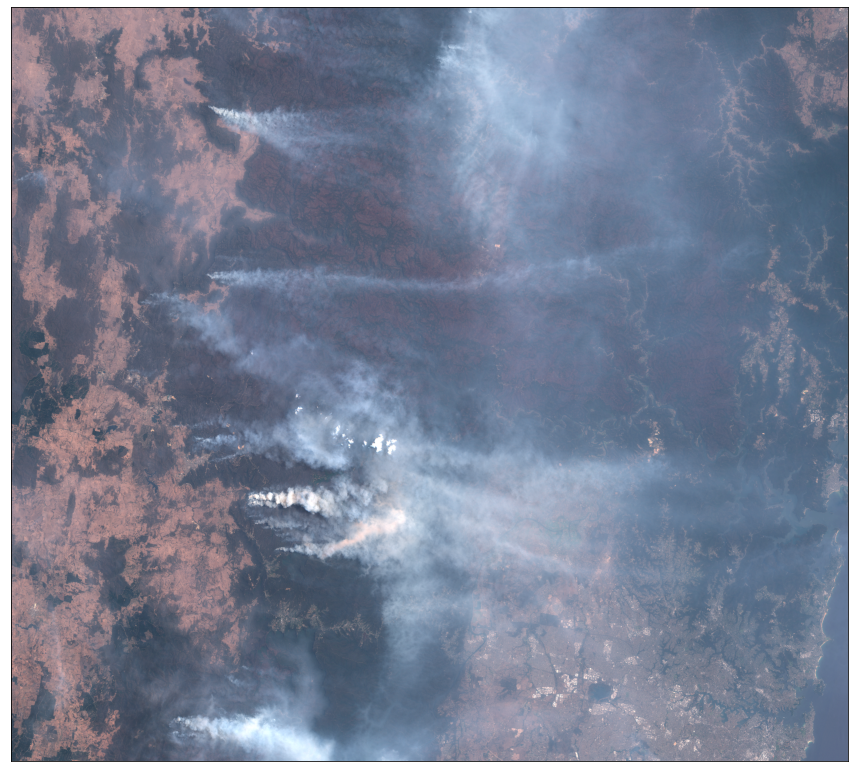

In [14]:
image = true_color_imgs[0]
print(f'Image type: {image.dtype}')

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5/255, clip_range=(0,1))

# Visualising Sentinel-2 indices - SWIR

Sentinel-2 images have [13 bands](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/radiometric). To learn more about Sentinel-2 MSI instrument and available products visit the [Sentinel-2 webpage](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi).

### Optimising the request 

We will retrieve the data from Sentinel Hub.

To get more details about how Sentinel Hub returns the values of the requested data visit: [How Are The Values Calculated Within Sentinel Hub And How Are They Returned As An Output?](https://www.sentinel-hub.com/faq/how-are-values-calculated-within-sentinel-hub-and-how-are-they-returned-output/)

When we are downloading big chunks of data, it is important to consider ways to optimize the request. One way to reduce the amount of data downloaded is to get raw digital numbers as `INT16` instead of getting reflectances which are `FLOAT32`. Less data means a faster download and a smaller usage of Sentinel Hub processing units.

In order to achieve this, we set the input units to `DN` (digital numbers) and the output `sampleType` argument to `INT16`. 

Given that Sentinel-2 has 13 bands, we have to set the output image type to the `TIFF` format via `MimeType.TIFF` in the request if we want to retrieve all the bands. In the cell below we are asking only for 3 bands but will use this procedure for exemplification.

The dynamic range of the digital numbers is 0-10000, so for visualisation we have to scale the downloaded data appropriately.

The following cell will return the bands B12, B8A and B04 necessary to compute the SWIR index of the Sentinel-2 Level 2A product. More information here: https://custom-scripts.sentinel-hub.com/sentinel-2/swir-rgb/

In [15]:
#define an evalscript with the function to get all 13 bands of the Sentinel-2 image
evalscript_SWIR = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B12", "B8A", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B12, sample.B8A, sample.B04];
    }
"""


#call the function

request_SWIR = SentinelHubRequest(
    evalscript=evalscript_SWIR,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2019-12-16', '2019-12-16'),
            mosaicking_order='leastCC'
    )],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=GoldCoast_bbox,
    size=GoldCoast_size,
    config=config
)

In [16]:
SWIR_response = request_SWIR.get_data()

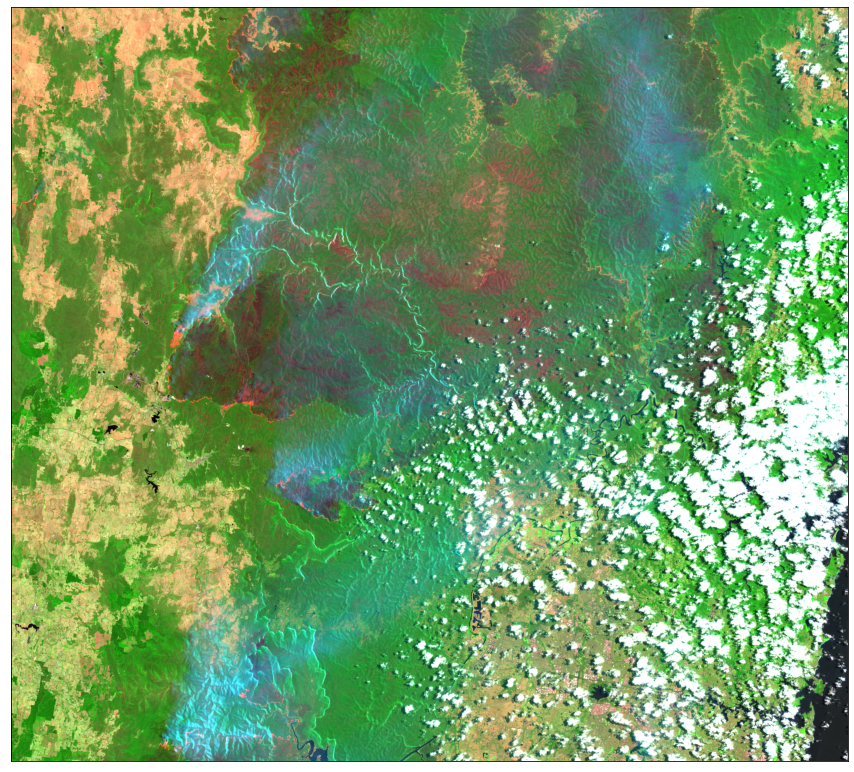

In [17]:
# Image showing the SWIR band B12
# Factor 1/1e4 due to the DN band values in the range 0-10000
# Factor 3.5 to increase the brightness
plot_image(SWIR_response[0], factor=2.5/255, clip_range=(0,1))

# Getting Carbon Monoxide Data from Sentinel-5p

In the following sections we will see how to access Sentinel-5p Level 2 data from Sentinel Hub using the xcube service, as well as the reprocessed Sentinel-5p Level 3 products which are displayed on EO Dashboard. 
On the reprocessed data, we will use the Sentinel Hub Statistical API to extract time series over the area of interest defined before.

For more informaiton about the Sentinel-5p Level 2 products please refer to the Algorithm Theoretical Basis Document (ATBD) available on [this page](http://www.tropomi.eu/data-products/carbon-monoxide).

In [18]:
from edc import print_info
print_info("sh-data-access")


***Notebook Title***  
Sentinel Hub data access using xcube

***Notebook Description***  
Euro Data Cube Sentinel Hub - data access


***Notebook Dependencies***  
This notebook requires an active subscription to:
* EDC Sentinel Hub


In [19]:
# xcube_sh imports
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers
from xcube_sh.viewer import ViewerServer

# xcube imports
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry

# Various utilities
import json
import xarray as xr
import shapely.geometry
import IPython.display
import zarr

In [20]:
%matplotlib inline

In [21]:
x1 = minlon # degree
y1 = minlat  # degree
x2 = maxlon  # degree
y2 = maxlat  # degree

bbox = x1, y1, x2, y2

Visualize the bounding box. If you don't see anything, please refer to EDC Setup example [here](https://eurodatacube.com/marketplace/notebooks/curated/EDC_Sentinel_Hub-Setup).

In [22]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

In [23]:
spatial_res = 0.035   # = 3.5 km in degree>

In [24]:
cube_config = CubeConfig(dataset_name='sentinel-5p-l2',
                         band_names=['CO'],
                         tile_size=[1835, 2338],
                         bbox=bbox,
                         spatial_res=spatial_res,
                         time_range=['2019-10-01', '2019-12-31'],
                         time_period='2D')

We define a request_collector as an observer for SH requests made, so we can show SH usage stats. This is a developer tool, useful for demonstration purposes too. Otherwise, this is not needed.

In [25]:
request_collector = Observers.request_collector()

Open a data cube:

In [26]:
cube = open_cube(cube_config, observer=request_collector)

In [27]:
cube

<xarray.Dataset>
Dimensions:    (time: 46, lat: 32, lon: 44, bnds: 2)
Coordinates:
  * lat        (lat) float64 -32.82 -32.85 -32.89 -32.92 ... -33.83 -33.87 -33.9
  * lon        (lon) float64 149.8 149.9 149.9 149.9 ... 151.2 151.3 151.3 151.3
  * time       (time) datetime64[ns] 2019-10-02 2019-10-04 ... 2019-12-31
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(46, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    CO         (time, lat, lon) float32 dask.array<chunksize=(1, 32, 44), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    title:                     sentinel-5p-l2 Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2022-07-18T07:57:09.341489
    time_coverage_start:       2019-10-01T00:00:00+00:00
    time_coverage_end:         2020-01-01T00:00:00+00:00
    time_coverage_duration:    P92DT0H0M0S
    time_coverage_resolution:  P2DT0H0M0S
    geospatial_lon_min:        149.815
    geospatial_lat_min:        -33.92
    geospatial_lon_max:        151.355
    geospatial_lat_max:        -32.800000000000004

No requests have been made yet. Requests are made only if data is actually required.

In [28]:
request_collector.stats

Note, the cube's time coordinates are monotonically increasing and the distance between two time steps is varying:

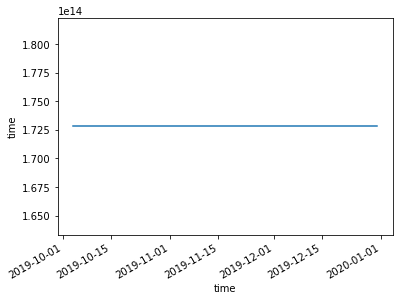

In [29]:
cube.time.diff(dim='time').plot.line()

In [30]:
#cube.CO
s5p_co = cube.CO
s5p_co

<xarray.DataArray 'CO' (time: 46, lat: 32, lon: 44)>
dask.array<open_dataset-aa7d65b96156118e47b6d897ec9c83baCO, shape=(46, 32, 44), dtype=float32, chunksize=(1, 32, 44), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -32.82 -32.85 -32.89 -32.92 ... -33.83 -33.87 -33.9
  * lon      (lon) float64 149.8 149.9 149.9 149.9 ... 151.2 151.3 151.3 151.3
  * time     (time) datetime64[ns] 2019-10-02 2019-10-04 ... 2019-12-31

To set the visualisation limits, get the maximum value in the dataset

In [31]:
import pandas as pd

co_values = list() 
timestamp = list()

for i in range(cube.time.shape[0]):
    co_values.append(np.nanmean(cube.CO.isel(time=i).values[0]))
    timestamp.append(cube.CO.isel(time=i).time.values)
        
assert len(co_values) == len(timestamp)
    
pd.DataFrame({'DateTime': timestamp, 'Mean CO': co_values})

/tmp/ipykernel_76/1595983457.py:7: RuntimeWarning: Mean of empty slice
  co_values.append(np.nanmean(cube.CO.isel(time=i).values[0]))


,DateTime,Mean CO
0,2019-10-02,0.026661
1,2019-10-04,0.029292
2,2019-10-06,0.029853
3,2019-10-08,0.024584
4,2019-10-10,0.024491
5,2019-10-12,NaN
6,2019-10-14,0.026865
7,2019-10-16,0.028427
8,2019-10-18,0.024629
9,2019-10-20,0.023203


In [32]:
s5p_co_1712 = cube.CO.sel(time='2019-12-17', method='nearest')

#cube.CO.sel(time='2019-12-16 10:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.08, cmap='rainbow', figsize=(10,9))

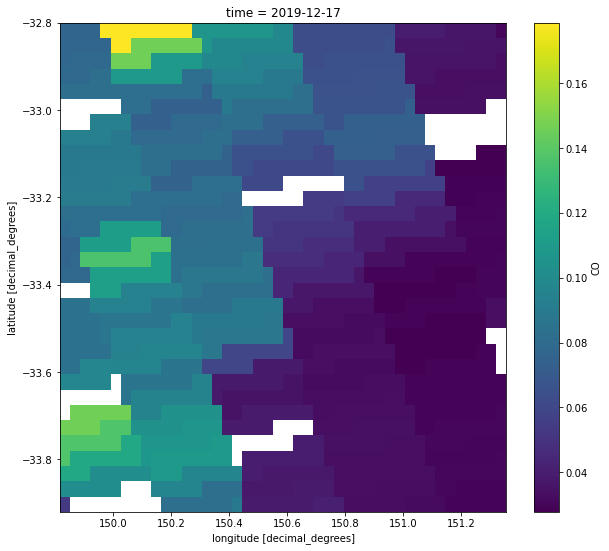

In [33]:
s5p_co_1712.plot.pcolormesh(cmap='viridis',figsize=(10,9))

## Accessing TROPOMI CO data with Statistical API

In [34]:
#!/usr/bin/python

from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import json

# Your client credentials
client_id = config.sh_client_id
client_secret = config.sh_client_secret

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_secret=client_secret)

header = {"content-type": "application/json"}

json_body = {
    "input": {
        "bounds": {
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            minlon,
                            minlat
                        ],
                        [
                            minlon,
                            maxlat
                        ],
                        [
                            maxlon,
                            maxlat
                        ],
                        [
                            maxlon,
                            minlat
                        ],
                        [
                            minlon,
                            minlat
                        ]
                    ]
                ]
            }
        },
        "data": [
            {
                "dataFilter": {

                },
                "type": "byoc-57a07405-8ec2-4b9c-a273-23e287c173f8"
            }
        ]
    },
    "aggregation": {
        "timeRange": {
            "from": "2019-11-01T00:00:00Z",
            "to": "2020-01-31T00:00:00Z"
        },
        "aggregationInterval": {
            "of": "P3D"
        },
        "width": 100,
        "height": 100,
        "evalscript": '''
            //VERSION=3\n
            function setup() {\n
            return {\n
                input: [{\n
                bands: [\n
                    \"co\",\n
                    \"dataMask\"\n
                ]\n
                }],\n
                output: [\n
                {\n
                    id: \"data\",\n
                    bands: 1,\n
                    sampleType: \"FLOAT32\"\n
                },\n
                {\n
                    id: \"dataMask\",\n
                    bands: 1\n
                }\n
                ]\n
            }\n
            }\n
            function evaluatePixel(samples) {\n
            let validValue = 1\n
            if (samples.co >= 1e20 ){\n
                validValue = 0\n
            }\n
            let index = samples.co;\n
            return {\n
                data:  [index],\n
                dataMask: [samples.dataMask * validValue]\n
            }\n
            }'''
        },
        "calculations": {
            "default": {

            }
        }
}

url = "https://services.sentinel-hub.com/api/v1/statistics"
resp = oauth.post(
    url, data =json.dumps(json_body), headers=header
)

if resp.status_code == 200:
    try:
        respjson = resp.json()
        response_status = respjson["status"]
    except Exception:
        print("Issue parsing response")

print(respjson)
respjson

{'data': [{'interval': {'from': '2019-11-01T00:00:00Z', 'to': '2019-11-04T00:00:00Z'}, 'outputs': {'data': {'bands': {'B0': {'stats': {'min': 61.183773040771484, 'max': 84.95490264892578, 'mean': 70.54207758483905, 'stDev': 2.820257352488022, 'sampleCount': 10000, 'noDataCount': 0}}}}}}, {'interval': {'from': '2019-11-04T00:00:00Z', 'to': '2019-11-07T00:00:00Z'}, 'outputs': {'data': {'bands': {'B0': {'stats': {'min': 54.97686004638672, 'max': 308.40643310546875, 'mean': 81.11943956108107, 'stDev': 41.42121614969195, 'sampleCount': 10000, 'noDataCount': 0}}}}}}, {'interval': {'from': '2019-11-07T00:00:00Z', 'to': '2019-11-10T00:00:00Z'}, 'outputs': {'data': {'bands': {'B0': {'stats': {'min': 67.62435913085938, 'max': 396.8648681640625, 'mean': 94.42522585754384, 'stDev': 40.57998364045338, 'sampleCount': 10000, 'noDataCount': 0}}}}}}, {'interval': {'from': '2019-11-10T00:00:00Z', 'to': '2019-11-13T00:00:00Z'}, 'outputs': {'data': {'bands': {'B0': {'stats': {'min': 41.2664680480957, 'max

{'data': [{'interval': {'from': '2019-11-01T00:00:00Z',
    'to': '2019-11-04T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 61.183773040771484,
        'max': 84.95490264892578,
        'mean': 70.54207758483905,
        'stDev': 2.820257352488022,
        'sampleCount': 10000,
        'noDataCount': 0}}}}}},
  {'interval': {'from': '2019-11-04T00:00:00Z', 'to': '2019-11-07T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 54.97686004638672,
        'max': 308.40643310546875,
        'mean': 81.11943956108107,
        'stDev': 41.42121614969195,
        'sampleCount': 10000,
        'noDataCount': 0}}}}}},
  {'interval': {'from': '2019-11-07T00:00:00Z', 'to': '2019-11-10T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 67.62435913085938,
        'max': 396.8648681640625,
        'mean': 94.42522585754384,
        'stDev': 40.57998364045338,
        'sampleCount': 10000,
        'noDataCount': 0}}}}}},
  {'interval': {'

In [35]:
from datetime import datetime


In [36]:
time_axis = [datetime.strptime(entry["interval"]["from"], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y/%m/%d") for entry in respjson["data"]]
means = [entry['outputs']['data']['bands']['B0']['stats']['mean'] for entry in respjson["data"]]
mins = [entry['outputs']['data']['bands']['B0']['stats']['min'] for entry in respjson["data"]]
maxs = [entry['outputs']['data']['bands']['B0']['stats']['max'] for entry in respjson["data"]]
std_devs = [entry['outputs']['data']['bands']['B0']['stats']['stDev'] for entry in respjson["data"]]
std_upper = [m+s for (m,s) in zip(means, std_devs)]
std_lower = [m-s for (m,s) in zip(means, std_devs)]

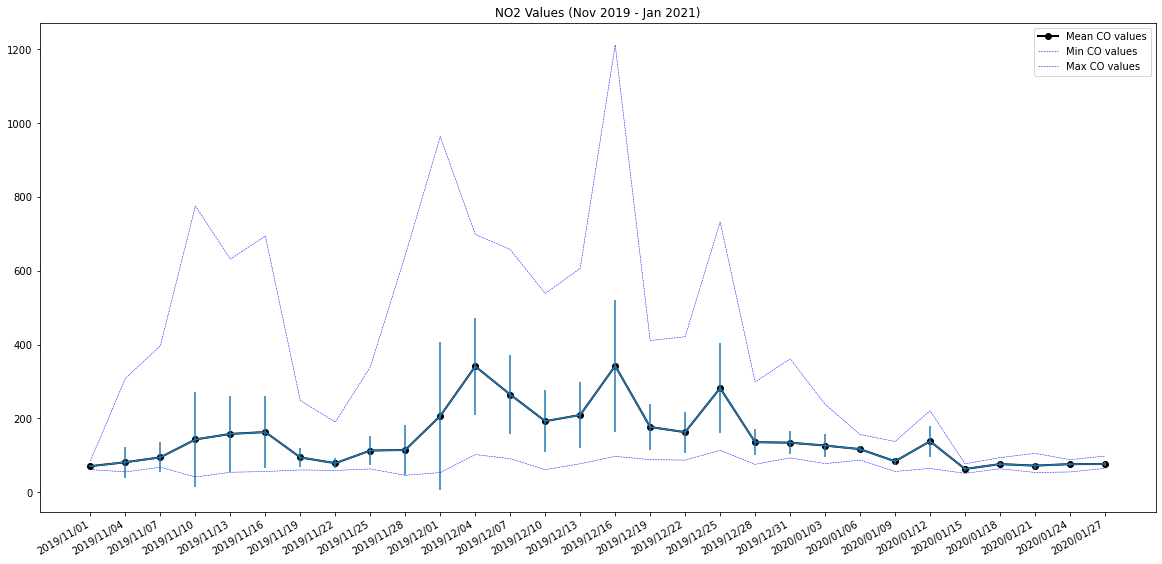

In [37]:
fig = plt.figure(figsize=(20,10))
# plot mean values 
plt.plot_date(time_axis, means, linestyle='solid', linewidth=2, color="black", label="Mean CO values")

# plot standard deviation error bars
plt.errorbar(time_axis, means, yerr=std_devs, linestyle="-")

# plot min/max lines
plt.plot(time_axis, mins, linestyle="--", linewidth=0.5, color="blue", label="Min CO values")
plt.plot(time_axis, maxs, linestyle="--", linewidth=0.5, color="blue", label="Max CO values")

plt.title('NO2 Values (Nov 2019 - Jan 2021)')
plt.legend()
fig.autofmt_xdate()
plt.show()